(Uncompleted) Notebook for training and testing the baseline neural network model using adjacency matrices of the AST format of the buffer overflow datapoints. In order for the matrices to be fed into the neural network, they must all be of the same dimensions. We currently pick a subset of the data with small-ish AST matrices (614x614)

# Colab Setup

In [1]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle
!mkdir -p /project/code
%cd /project/code

--2019-07-30 11:40:48--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-07-30 11:40:48--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   232MB/s    in 5.6s    

2019-07-30 11:41:08 (223 MB/s) - ‘adj.pickle’ saved [1320521199/132052119

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [2]:
!pip install sklearn

     |████████████████████████████████| 6.7MB 4.0MB/s eta 0:00:01     |█████████████████████           | 4.4MB 4.0MB/s eta 0:00:01     |████████████████████████▍       | 5.1MB 4.0MB/s eta 0:00:01     |██████████████████████████      | 5.5MB 4.0MB/s eta 0:00:01     |████████████████████████████    | 5.8MB 4.0MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split


run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [4]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [5]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [6]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'matrix'})

In [7]:
adj_df = pd.merge(labels, adj, on='testcase_ID')

In [8]:
adj_df = adj_df[['testcase_ID', 'matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [9]:
adj_df['matrix_size'] = adj_df.matrix.apply(lambda x: x.shape[0])

In [12]:
adj_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [10]:
matrix_size = 614
adj_df = adj_df[adj_df['matrix_size'] <= matrix_size]
len(adj_df)

16128

In [11]:
adj_df.head()

,testcase_ID,matrix,bug,matrix_size
0,-234271,"(0, 1)\t1\n (0, 2)\t1\n (0, 3)\t1\n (0, 4...",True,395
1,-234270,"(0, 1)\t1\n (0, 2)\t1\n (0, 3)\t1\n (0, 4...",True,386
2,-234269,"(0, 1)\t1\n (0, 2)\t1\n (0, 3)\t1\n (0, 4...",True,395
3,-234263,"(0, 1)\t1\n (0, 2)\t1\n (0, 3)\t1\n (0, 4...",True,385
4,-234260,"(0, 1)\t1\n (0, 2)\t1\n (0, 3)\t1\n (0, 4...",True,390


In [11]:
def bottom_right_matrix_size_corrector(matrix, size):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((size-rows, rows))
    col_corrector = csr_matrix((size, size-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [13]:
adj_df['matrix'] = adj_df['matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size))

In [12]:
testcase_ids = adj_df['testcase_ID'].values
adjacency_matrices = adj_df['matrix'].values
labels = adj_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, labels, batch_size):
        self.sparse_matrices = sparse_matrices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense, np.array(batch_labels)

Finally, we generate the train and test splits:

Load in out pre-generated training and test sets from the graph2vec dataset. We use the indices from these to extract the same set split in our adjacency dataset.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(adjacency_matrices, labels, test_size=0.2, random_state = 0)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [19]:
batch_size = 96
epochs = 5
num_samples = len(labels)

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 16128, (614, 614), (96, 614, 614), 168, (2, 2), 1)

In [20]:
model = Sequential()

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

W0730 11:43:18.441387 140688343668608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 11:43:18.506930 140688343668608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 11:43:18.519141 140688343668608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 11:43:18.571600 140688343668608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 11:43:18.667378 140688343668608 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 613, 613, 32)      160       
_________________________________________________________________
activation_1 (Activation)    (None, 613, 613, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 307, 307, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 306, 306, 32)      4128      
_________________________________________________________________
activation_2 (Activation)    (None, 306, 306, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 153, 153, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 152, 152, 32)      4128      
__________

In [21]:
training_batch_generator = SparseToDenseGenerator(x_train, y_train, batch_size)

model.fit_generator(
    generator=training_batch_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2435s 14s/step - loss: 0.5138 - acc: 0.7184
Epoch 2/5
168/168 [==============================] - 2390s 14s/step - loss: 0.1513 - acc: 0.9434
Epoch 3/5
168/168 [==============================] - 2384s 14s/step - loss: 0.0553 - acc: 0.9829
Epoch 4/5
168/168 [==============================] - 2383s 14s/step - loss: 0.0318 - acc: 0.9906
Epoch 5/5
168/168 [==============================] - 2396s 14s/step - loss: 0.0127 - acc: 0.9965


In [0]:
 import pickle

In [0]:
with open('../data/adjacency-matrix-model-binary.pickle','wb') as f:
    pickle.dump(model,f)

# Evaluation

In [0]:
model = None
with open('../data/adjacency-matrix-model-binary.pickle','rb') as f:
    model = pickle.load(f)

W0729 09:00:06.035389 139812898600832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 09:00:06.085936 139812898600832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 09:00:06.138282 139812898600832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 09:00:06.235374 139812898600832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 09:00:06.237010 139812898600832 deprecation_wrap

In [24]:
test_batch_generator = SparseToDenseGenerator(x_test, y_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[0.02511249791915365, 0.9934903888028376]

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, batch_size):
        self.sparse_matrices = sparse_matrices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(x_test, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

In [0]:
import numpy as np

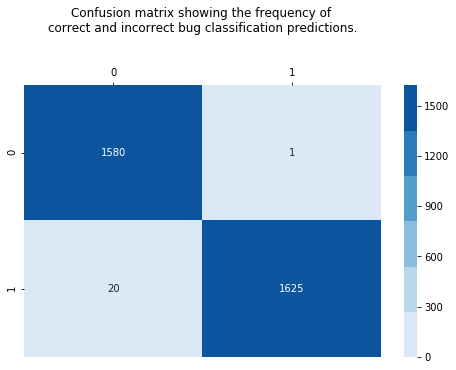

In [37]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    y_test.astype(int),
    np.rint(y_predict),
)

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

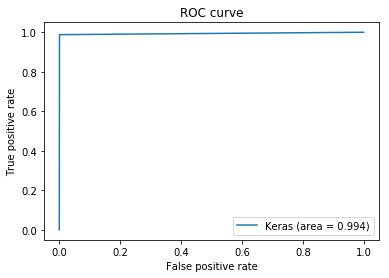

In [33]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [35]:
fpr_nn, fnr_nn

(0.0006150061500615006, 0.0125)

## Random Padding (translational invariance)

In [13]:
import random

In [24]:
def random_padder(matrix, size):
    '''
    Randomly pads matrix with zeros to the desired size
    '''
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    rand = random.randint(matrix.shape[0],size)
    
    tl_row_corrector = csr_matrix((rand-rows, rows))
    tl_col_corrector = csr_matrix((rand, rand-columns))
    
    tl_matrix = vstack([tl_row_corrector, matrix])
    tl_matrix = hstack([tl_col_corrector, tl_matrix])
    
    rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
    br_row_corrector = csr_matrix((size-rows, rows))
    br_col_corrector = csr_matrix((size, size-columns))

    br_matrix = vstack([tl_matrix, br_row_corrector])
    br_matrix = hstack([br_matrix, br_col_corrector])

    br_matrix = br_matrix.astype(np.int)
    
    return br_matrix

In [34]:
rand_adj_df = adj_df.copy()

In [35]:
rand_adj_df['matrix'] = rand_adj_df['matrix'].apply(lambda m: random_padder(m, matrix_size))

In [19]:
testcase_ids = rand_adj_df['testcase_ID'].values
adjacency_matrices = rand_adj_df['matrix'].values
labels = rand_adj_df['bug'].values

In [39]:
rand_adj_df.matrix.iloc[2].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
x_train, x_test, y_train, y_test = train_test_split(adjacency_matrices, labels, test_size=0.2, random_state = 0)